In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

# change directory
%cd drive/MyDrive/Final Project

Mounted at /content/drive
/content/drive/MyDrive/Final Project


In [4]:
movies = pd.read_csv("data/movies_genre&overview.csv",index_col="Unnamed: 0")
len(movies)

1713

In [5]:
movies.head()

,genre_list,overview
Mortal Kombat,"['Action', 'Fantasy']",For nine generations an evil sorcerer has been...
The Neverending Story III: Escape from Fantasia,['Fantasy'],A young boy must restore order when a group of...
Interview with the Vampire,"['Horror', 'Romance']","A vampire relates his epic life story of love,..."
Beyond Bedlam,['Horror'],An experiment gone awry places a neurologist (...
Wolf,['Fantasy'],Publisher Will Randall becomes a werewolf and ...


# 1st approach (bad)

## Data preprocessing

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

movies_vec = list(movies["overview"])
vec = CountVectorizer(ngram_range = (1,3))
movies_vec = vec.fit_transform(movies_vec)
movies_vec = movies_vec.toarray()
print(movies_vec.shape)

(1200, 111310)


In [5]:
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

labels = []

for i in movies["genre_list"].values:

  labels.append(literal_eval(i))

# Transform labels

mlb = MultiLabelBinarizer()

X = movies_vec
Y = mlb.fit_transform(labels)

# data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [6]:
Y.shape

(1200, 7)

## Model preparation

In [7]:
# PLOT LOSS AND ACCURACY HISTORY
def plot_loss_accuracy(history, validation=False):
    loss = history['loss']
    acc = history['accuracy']
    legend = ['train']
    if validation:
        legend.append('validation')
        val_loss = history['val_loss']
        val_acc = history['val_accuracy']

    fig = plt.figure(figsize=(10, 6))
    fig.suptitle('Log Loss and Accuracy over iterations')

    # add_subplot(rows, columns, index)
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss)
    if validation:
        ax.plot(val_loss)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Log Loss')
    ax.legend(legend, loc='upper right')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(acc)
    if validation:
        ax.plot(val_acc)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Accuracy')
    ax.legend(legend, loc='lower right')

In [8]:
# NEURAL NETWORKS
def build_model(input_dimension = 2, perceptrons=10, hidden_layers=1, LR=0.2):
    # define model
    model = tf.keras.models.Sequential()

    # add layers
    # Dense(perceptrons, input_dim (features), activation)

    model.add(tf.keras.layers.Dense(perceptrons, input_dim=input_dimension, activation='relu')) # hidden layer 1
    for i in range(hidden_layers-1):
        model.add(tf.keras.layers.Dense(perceptrons, activation='relu')) # additional hidden layers
    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid')) # output layer
    model.summary()

    # compile model
    my_opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=my_opt, metrics=['accuracy'])

    return model

def fit_model(model, X, Y, epochs=100, validation_split=None):
    # fit the model (fit: returns history of training)
    history = model.fit( X, Y, epochs=epochs, verbose=2, validation_split=validation_split)

    # final prediction (after training)
    y_hat = model.predict(X).flatten()

    return [history, y_hat]

## Training

In [9]:
# BUILD AND FIT A MODEL
model = build_model(input_dimension = X.shape[1], perceptrons=100, hidden_layers=2, LR=0.01)
loss_accuracy = fit_model(model, X_train, Y_train, epochs=20, validation_split=0.2)[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11131100  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 11,141,907
Trainable params: 11,141,907
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
21/21 - 7s - loss: 0.4706 - accuracy: 0.4524 - val_loss: 0.4276 - val_accuracy: 0.5238 - 7s/epoch - 313ms/step
Epoch 2/20
21/21 - 1s - loss: 0.1526 - accuracy: 0.6116 - val_loss: 0.4823 - val_accuracy: 0.5655 - 510ms/epoch - 24ms/step
Epoch 3/20
21/21 - 0s - loss: 0.0547 - accuracy: 0.6875 - val_

## Plotting and testing

Test loss: 1.0554553270339966
Test accuracy: 0.2666666805744171


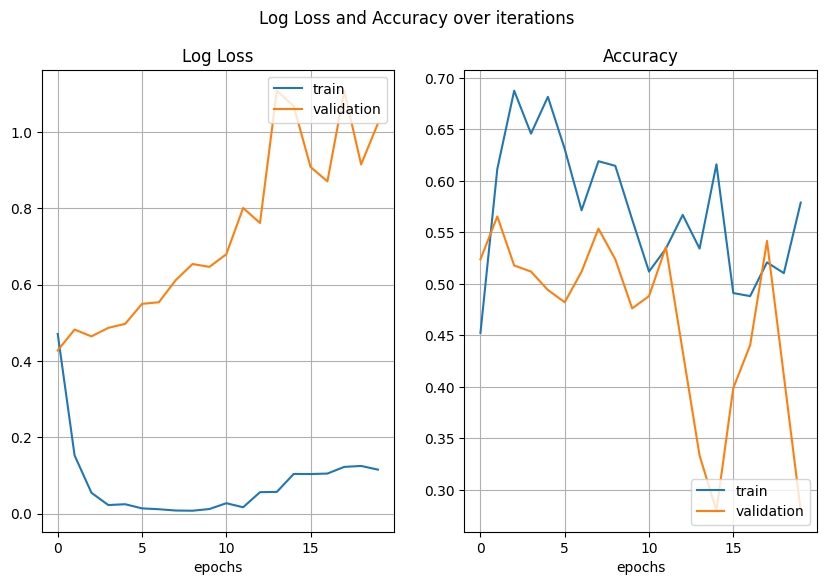

In [10]:
# PLOT TRAINING HISTORY
plot_loss_accuracy(loss_accuracy.history, validation=True)

# TEST THE MODEL
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [11]:
# Test 1

i = 5

test_1 = model.predict(vec.transform([movies_whole["overview"][i]]),verbose=0)
print("Prediction: ",mlb.inverse_transform(np.round(test_1))[0])
print("True genre: ", movies_whole["genre_list"][i])

Prediction:  ('Comedy', 'Horror')
True genre:  ['Comedy', 'Horror']


In [12]:
# Test 2

i = 10000

test_2 = model.predict(vec.transform([movies_whole["overview"][i]]),verbose=0)

print("Prediction: ",mlb.inverse_transform(np.round(test_2))[0])
print("True genre: ", movies_whole["genre_list"][i])

Prediction:  ('Drama', 'Romance')
True genre:  ['Drama']


In [13]:
# Test 3

i = 12345

test_3 = model.predict(vec.transform([movies_whole["overview"][i]]),verbose=0)

print("Prediction: ",mlb.inverse_transform(np.round(test_3))[0])
print("True genre: ", movies_whole["genre_list"][i])

Prediction:  ('Comedy', 'Drama', 'Romance')
True genre:  ['Drama']


In [14]:
# Test 4

i = 4506

test_4 = model.predict(vec.transform([movies_whole["overview"][i]]),verbose=0)

print("Prediction: ",mlb.inverse_transform(np.round(test_4))[0])
print("True genre: ", movies_whole["genre_list"][i])

Prediction:  ('Drama',)
True genre:  ['Drama']


# 2nd approach

## Data preprocessing

In [6]:
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


X = movies["overview"].values


labels = []

for i in movies["genre_list"].values:

  labels.append(literal_eval(i))

# Transform labels

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(labels)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [7]:
# Tokenizing the Xs

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding="post")

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding="post")

In [8]:
X_train

array([[ 1068,     5,  3132, ...,     0,     0,     0],
       [ 4893,  4894,  4895, ...,     0,     0,     0],
       [  204,    14,     2, ...,     0,     0,     0],
       ...,
       [  230,   416, 10674, ...,     0,     0,     0],
       [ 4884,     8,   917, ...,     0,     0,     0],
       [    3,   298, 10678, ...,     0,     0,     0]], dtype=int32)

In [9]:
vocab_size

10698

In [10]:
len(X_train[0])

178

## Model preparation

In [11]:
# PLOT LOSS AND ACCURACY HISTORY
def plot_loss_accuracy(history, validation=False):
    loss = history['loss']
    acc = history['accuracy']
    legend = ['train']
    if validation:
        legend.append('validation')
        val_loss = history['val_loss']
        val_acc = history['val_accuracy']

    fig = plt.figure(figsize=(10, 6))
    fig.suptitle('Log Loss and Accuracy over iterations')

    # add_subplot(rows, columns, index)
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss)
    if validation:
        ax.plot(val_loss)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Log Loss')
    ax.legend(legend, loc='upper right')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(acc)
    if validation:
        ax.plot(val_acc)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Accuracy')
    ax.legend(legend, loc='lower right')

In [12]:
# NEURAL NETWORKS
def build_model(embed_dim=64, perceptrons=10, hidden_layers=1, LR=0.2):

    # for the Embedding layer
    max_len = len(X_train[0])


    # define model
    model = tf.keras.models.Sequential()

    # add layers

    model.add(tf.keras.layers.Embedding(vocab_size,embed_dim,input_length=max_len))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(perceptrons, activation='relu'))

    if hidden_layers != 0:
      for i in range(hidden_layers-1):
          model.add(tf.keras.layers.Dense(perceptrons, activation='relu')) # additional hidden layers

    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid')) # output layer
    model.summary()

    # compile model
    my_opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=my_opt, metrics=['accuracy'])

    return model

def fit_model(model, X, Y, epochs=100, validation_split=None):
    # fit the model (fit: returns history of training)
    history = model.fit( X, Y, epochs=epochs, verbose=2, validation_split=validation_split)

    # final prediction (after training)
    y_hat = model.predict(X).flatten()

    return [history, y_hat]

## Training

In [25]:
# BUILD AND FIT A MODEL
model = build_model(embed_dim=256, perceptrons=256, hidden_layers=1, LR=0.01)
loss_accuracy = fit_model(model, X_train, Y_train, epochs=10, validation_split=0.2)[0]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 178, 256)          2738688   
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,805,765
Trainable params: 2,805,765
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 - 8s - loss: 0.4495 - accuracy: 0.5735 - val_loss: 0.4537 - val_accuracy: 0.5333 - 8s/epoch -

## Plotting and testing

Test loss: 0.509013831615448
Test accuracy: 0.7198443412780762


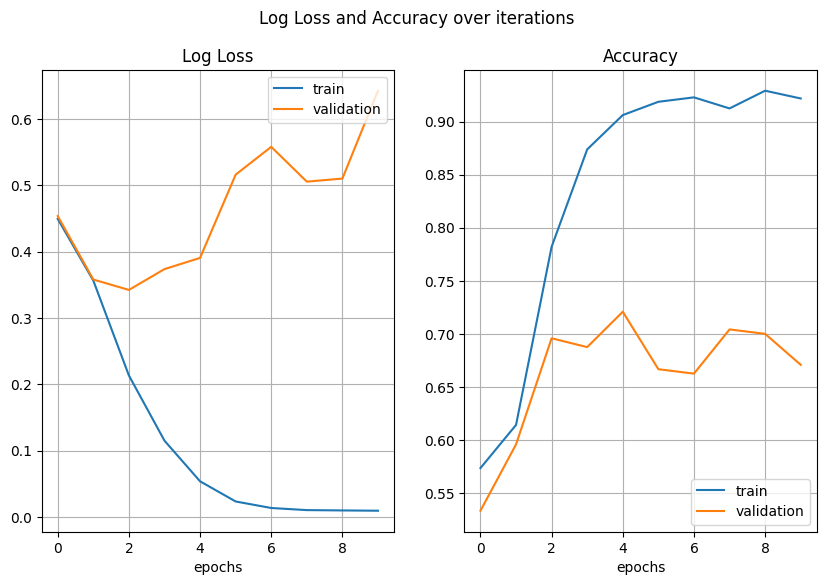

In [26]:
# PLOT TRAINING HISTORY
plot_loss_accuracy(loss_accuracy.history, validation=True)

# TEST THE MODEL
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [27]:
# Test 1

i = 123

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

2/2 [==============================] - 0s 4ms/step
Prediction:  ('Fantasy', 'Horror')
True value:  ['Action']


In [42]:
# Test 2

i = 561

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

16/16 [==============================] - 0s 2ms/step
Prediction:  ('Fantasy', 'Horror')
True value:  ['Horror']


In [29]:
# Test 3

i = 676

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

4/4 [==============================] - 0s 3ms/step
Prediction:  ('Horror',)
True value:  ['Horror']


In [41]:
# Test 4

i = 23

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

7/7 [==============================] - 0s 2ms/step
Prediction:  ('Fantasy', 'Horror')
True value:  ['Horror']


In [31]:
# Test 5

i = 973

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

17/17 [==============================] - 0s 2ms/step
Prediction:  ('Fantasy', 'Horror')
True value:  ['Horror']


In [32]:
# Test 6

i = 9

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

10/10 [==============================] - 0s 2ms/step
Prediction:  ('Family', 'Horror')
True value:  ['Family', 'Fantasy']


In [33]:
# Test 7

i = 1400

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

3/3 [==============================] - 0s 3ms/step
Prediction:  ('Action', 'Fantasy', 'Horror')
True value:  ['Horror']


In [34]:
# Test 8

i = 1689

overview = movies["overview"].values[i]

overview = tokenizer.texts_to_sequences(overview)
overview = pad_sequences(overview,padding="post")

prediction = model.predict(overview)

print("Prediction: ", mlb.inverse_transform(np.round(prediction))[0])
print("True value: ", movies["genre_list"].values[i])

3/3 [==============================] - 0s 5ms/step
Prediction:  ('Action',)
True value:  ['Horror']
